<a href="https://colab.research.google.com/github/ngoda/Conversations/blob/master/ch6BOOK2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


*italicised text*CHAPTER 6*

** Implementation of LSTM**

In [10]:
import sys

# Append parent directory to the system path.
sys.path.append('..')

from common.np import *  # Import NumPy operations.
from common.layers import *  # Import layers from common.layers.
from common.functions import sigmoid  # Import sigmoid function from common.functions.

class LSTM:
    # Initialize the LSTM layer.
    def __init__(self, Wx, Wh, b):
        # Parameters: input weights (Wx), hidden state weights (Wh), biases (b).
        self.params = [Wx, Wh, b]
        # Gradients: gradients with respect to input weights (dWx), hidden state weights (dWh), biases (db).
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        # Cache: store intermediate values for backward pass.
        self.cache = None

    # Forward pass of the LSTM layer.
    def forward(self, x, h_prev, c_prev):
        # Unpack parameters.
        Wx, Wh, b = self.params
        # Get dimensions.
        N, H = h_prev.shape

        # Calculate the affine transformation.
        A = np.dot(x, Wx) + np.dot(h_prev, Wh) + b

        # Split the activation matrix.
        f = A[:, :H]
        g = A[:, H:2*H]
        i = A[:, 2*H:3*H]
        o = A[:, 3*H:]

        # Apply activation functions.
        f = sigmoid(f)
        g = np.tanh(g)
        i = sigmoid(i)
        o = sigmoid(o)

        # Calculate the next cell state and hidden state.
        c_next = f * c_prev + g * i  # Ct
        h_next = o * np.tanh(c_next)

        # Cache intermediate values for backward pass.
        self.cache = (x, h_prev, c_prev, i, f, g, o, c_next)
        return h_next, c_next

    # Backward pass of the LSTM layer.
    def backward(self, dh_next, dc_next):
        # Unpack parameters and cache.
        Wx, Wh, b = self.params
        x, h_prev, c_prev, i, f, g, o, c_next = self.cache

        # Calculate the derivative of the tanh function.
        tanh_c_next = np.tanh(c_next)

        # Calculate the derivative of the loss with respect to the cell state.
        ds = dc_next + (dh_next * o) * (1 - tanh_c_next ** 2)

        # Calculate the derivative of the cell state with respect to previous cell state.
        dc_prev = ds * f

        # Calculate the derivatives of gate activations.
        di = ds * g
        df = ds * c_prev
        do = dh_next * tanh_c_next
        dg = ds * i

        # Calculate gradients of gate activations.
        di *= i * (1 - i)
        df *= f * (1 - f)
        do *= o * (1 - o)
        dg *= (1 - g ** 2)

        # Concatenate gate gradients.
        dA = np.hstack((df, dg, di, do))

        # Calculate gradients of parameters.
        dWh = np.dot(h_prev.T, dA)
        dWx = np.dot(x.T, dA)
        db = dA.sum(axis=0)

        # Store gradients.
        self.grads[0][...] = dWx
        self.grads[1][...] = dWh
        self.grads[2][...] = db

        # Calculate gradient with respect to input.
        dx = np.dot(dA, Wx.T)
        # Calculate gradient with respect to previous hidden state.
        dh_prev = np.dot(dA, Wh.T)

        return dx, dh_prev, dc_prev


**Implementation of Time LSTM**

In [11]:
class TimeLSTM:
    # Initialize the TimeLSTM layer.
    def __init__(self, Wx, Wh, b, stateful=False):
        # Parameters: input weights (Wx), hidden state weights (Wh), biases (b).
        self.params = [Wx, Wh, b]
        # Gradients: gradients with respect to input weights (dWx), hidden state weights (dWh), biases (db).
        self.grads = [np.zeros_like(Wx), np.zeros_like(Wh), np.zeros_like(b)]
        # LSTM layers for each time step.
        self.layers = None
        # Hidden state (h), cell state (c), and gradient of hidden state (dh).
        self.h, self.c = None, None
        self.dh = None
        # Whether the layer is stateful (i.e., maintains hidden and cell states between batches).
        self.stateful = stateful

    # Forward pass of the TimeLSTM layer.
    def forward(self, xs):
        # Unpack parameters.
        Wx, Wh, b = self.params
        # Get dimensions.
        N, T, D = xs.shape
        H = Wh.shape[0]

        # Initialize list to store LSTM layers.
        self.layers = []
        # Initialize array to store hidden states for each time step.
        hs = np.empty((N, T, H), dtype='f')

        # Initialize hidden state and cell state if not stateful or not initialized.
        if not self.stateful or self.h is None:
            self.h = np.zeros((N, H), dtype='f')
        if not self.stateful or self.c is None:
            self.c = np.zeros((N, H), dtype='f')

        # Iterate over each time step.
        for t in range(T):
            # Create LSTM layer for the current time step.
            layer = LSTM(*self.params)
            # Perform forward pass through LSTM layer.
            self.h, self.c = layer.forward(xs[:, t, :], self.h, self.c)
            # Store the hidden state for the current time step.
            hs[:, t, :] = self.h
            # Store the LSTM layer for backpropagation.
            self.layers.append(layer)

        return hs  # Return hidden states for each time step.

    # Backward pass of the TimeLSTM layer.
    def backward(self, dhs):
        # Unpack parameters.
        Wx, Wh, b = self.params
        # Get dimensions.
        N, T, H = dhs.shape
        D = Wx.shape[0]

        # Initialize array to store gradients of input data for each time step.
        dxs = np.empty((N, T, D), dtype='f')
        # Initialize gradients of hidden state (dh) and cell state (dc).
        dh, dc = 0, 0

        # Initialize list to store gradients of LSTM layer parameters.
        grads = [0, 0, 0]
        # Iterate over each time step in reverse order.
        for t in reversed(range(T)):
            # Retrieve LSTM layer for the current time step.
            layer = self.layers[t]
            # Perform backward pass through LSTM layer.
            dx, dh, dc = layer.backward(dhs[:, t, :] + dh, dc)
            # Store gradients of input data for the current time step.
            dxs[:, t, :] = dx
            # Accumulate gradients of LSTM layer parameters.
            for i, grad in enumerate(layer.grads):
                grads[i] += grad

        # Update gradients of TimeLSTM layer parameters.
        for i, grad in enumerate(grads):
            self.grads[i][...] = grad
        # Update gradient of hidden state.
        self.dh = dh
        return dxs  # Return gradients of input data for each time step.

    # Set the hidden state (and optionally the cell state) of the TimeLSTM layer.
    def set_state(self, h, c=None):
        self.h, self.c = h, c

    # Reset the hidden state (and optionally the cell state) of the TimeLSTM layer.
    def reset_state(self):
        self.h, self.c = None, None


**Language Model using LSTM**

In [12]:
# Import necessary modules.
import sys

# Append parent directory to the system path.
sys.path.append('..')

# Import layers from common.time_layers and BaseModel from common.base_model.
from common.time_layers import *
from common.base_model import BaseModel

# Define Rnnlm class inheriting from BaseModel.
class Rnnlm(BaseModel):
    # Initialize the Rnnlm model.
    def __init__(self, vocab_size=10000, wordvec_size=100, hidden_size=100):
        V, D, H = vocab_size, wordvec_size, hidden_size
        rn = np.random.randn

        # Initialize weights and biases.
        embed_W = (rn(V, D) / 100).astype('f')
        lstm_Wx = (rn(D, 4 * H) / np.sqrt(D)).astype('f')
        lstm_Wh = (rn(H, 4 * H) / np.sqrt(H)).astype('f')
        lstm_b = np.zeros(4 * H).astype('f')
        affine_W = (rn(H, V) / np.sqrt(H)).astype('f')
        affine_b = np.zeros(V).astype('f')

        # Create layers.
        self.layers = [
            TimeEmbedding(embed_W),
            TimeLSTM(lstm_Wx, lstm_Wh, lstm_b, stateful=True),
            TimeAffine(affine_W, affine_b)
        ]
        self.loss_layer = TimeSoftmaxWithLoss()
        self.lstm_layer = self.layers[1]

        # Collect parameters and gradients.
        self.params, self.grads = [], []
        for layer in self.layers:
            self.params += layer.params
            self.grads += layer.grads

    # Make predictions.
    def predict(self, xs):
        for layer in self.layers:
            xs = layer.forward(xs)
        return xs

    # Compute forward pass.
    def forward(self, xs, ts):
        score = self.predict(xs)
        loss = self.loss_layer.forward(score, ts)
        return loss

    # Compute backward pass.
    def backward(self, dout=1):
        dout = self.loss_layer.backward(dout)
        for layer in reversed(self.layers):
            dout = layer.backward(dout)
        return dout

    # Reset the state of the LSTM layer.
    def reset_state(self):
        self.lstm_layer.reset_state()


**Training Code of Rnnlm**

| 에폭 1 |  반복 1 / 1327 | 시간 0[s] | 퍼플렉서티 9998.41
| 에폭 1 |  반복 21 / 1327 | 시간 6[s] | 퍼플렉서티 2825.94
| 에폭 1 |  반복 41 / 1327 | 시간 13[s] | 퍼플렉서티 1238.97
| 에폭 1 |  반복 61 / 1327 | 시간 18[s] | 퍼플렉서티 972.94
| 에폭 1 |  반복 81 / 1327 | 시간 25[s] | 퍼플렉서티 783.18
| 에폭 1 |  반복 101 / 1327 | 시간 31[s] | 퍼플렉서티 652.44
| 에폭 1 |  반복 121 / 1327 | 시간 38[s] | 퍼플렉서티 648.86
| 에폭 1 |  반복 141 / 1327 | 시간 44[s] | 퍼플렉서티 592.88
| 에폭 1 |  반복 161 / 1327 | 시간 51[s] | 퍼플렉서티 577.93
| 에폭 1 |  반복 181 / 1327 | 시간 56[s] | 퍼플렉서티 574.62
| 에폭 1 |  반복 201 / 1327 | 시간 64[s] | 퍼플렉서티 499.44
| 에폭 1 |  반복 221 / 1327 | 시간 69[s] | 퍼플렉서티 480.54
| 에폭 1 |  반복 241 / 1327 | 시간 76[s] | 퍼플렉서티 441.92
| 에폭 1 |  반복 261 / 1327 | 시간 82[s] | 퍼플렉서티 464.87
| 에폭 1 |  반복 281 / 1327 | 시간 88[s] | 퍼플렉서티 444.32
| 에폭 1 |  반복 301 / 1327 | 시간 94[s] | 퍼플렉서티 393.36
| 에폭 1 |  반복 321 / 1327 | 시간 100[s] | 퍼플렉서티 341.40
| 에폭 1 |  반복 341 / 1327 | 시간 107[s] | 퍼플렉서티 399.22
| 에폭 1 |  반복 361 / 1327 | 시간 112[s] | 퍼플렉서티 401.93
| 에폭 1 |  반복 381 / 1327 | 시간 119[s] | 퍼플렉서티 328.40
|

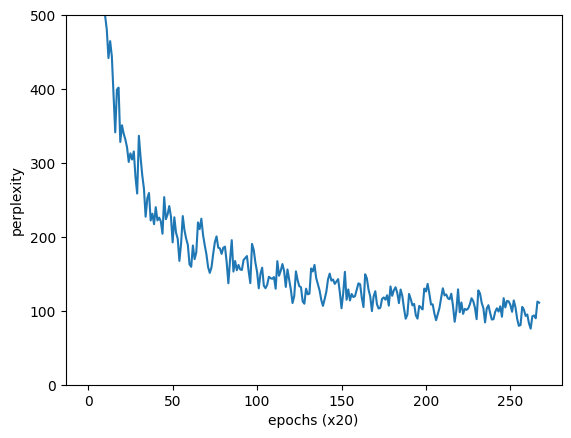

퍼플렉서티 평가 중 ...
234 / 235
Test perplexity:  136.2765370728615


In [13]:
# Import necessary modules.
import sys

# Append parent directory to the system path.
sys.path.append('..')

# Import optimizer, trainer, evaluation function, and dataset from common.
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity
from dataset import ptb

# Set hyperparameters.
batch_size = 20
wordvec_size = 100
hidden_size = 100  # Number of elements in the hidden state vector of the RNN.
time_size = 35     # Size of the unfolded RNN.
lr = 20.0
max_epoch = 4
max_grad = 0.25

# Load training and test data.
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_test, _, _ = ptb.load_data('test')
vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

# Create the Rnnlm model.
model = Rnnlm(vocab_size, wordvec_size, hidden_size)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

# Train the model with gradient clipping.
trainer.fit(xs, ts, max_epoch, batch_size, time_size, max_grad,
            eval_interval=20)
trainer.plot(ylim=(0, 500))

# Evaluate the model on the test data.
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('Test perplexity: ', ppl_test)

# Save the parameters.
model.save_params()


In [ ]:
%matplotlib inline
import sys
sys.path.append('..')
from common import config
# GPU에서 실행하려면 아래 주석을 해제하세요(CuPy 필요).
# ==============================================
config.GPU = True
# ==============================================
from common.optimizer import SGD
from common.trainer import RnnlmTrainer
from common.util import eval_perplexity, to_gpu
from dataset import ptb
from better_rnnlm import BetterRnnlm

# 하이퍼파라미터 설정
batch_size = 20
wordvec_size = 650
hidden_size = 650
time_size = 35
lr = 20.0
max_epoch = 3
max_grad = 0.25
dropout = 0.5


# 학습 데이터 읽기
corpus, word_to_id, id_to_word = ptb.load_data('train')
corpus_val, _, _ = ptb.load_data('val')
corpus_test, _, _ = ptb.load_data('test')

if config.GPU:
    corpus = to_gpu(corpus)
    corpus_val = to_gpu(corpus_val)
    corpus_test = to_gpu(corpus_test)

vocab_size = len(word_to_id)
xs = corpus[:-1]
ts = corpus[1:]

model = BetterRnnlm(vocab_size, wordvec_size, hidden_size, dropout)
optimizer = SGD(lr)
trainer = RnnlmTrainer(model, optimizer)

best_ppl = float('inf')
for epoch in range(max_epoch):
    trainer.fit(xs, ts, max_epoch=1, batch_size=batch_size,
                time_size=time_size, max_grad=max_grad)

    model.reset_state()
    ppl = eval_perplexity(model, corpus_val)
    print('검증 퍼플렉서티: ', ppl)

    if best_ppl > ppl:
        best_ppl = ppl
        model.save_params()
    else:
        lr /= 4.0
        optimizer.lr = lr

    model.reset_state()
    print('-' * 50)


# 테스트 데이터로 평가
model.reset_state()
ppl_test = eval_perplexity(model, corpus_test)
print('Test perplexity: ', ppl_test)

